# Points by Ref Analysis

In [200]:
from src.fantasy_football_v2.data.generate_dataframes.generate_weekly_points_df import generate_weekly_points_df
from src.fantasy_football_v2.data.generate_dataframes.generate_ref_df import generate_ref_df
from src.fantasy_football_v2.data.generate_dataframes.generate_game_df import generate_game_df

import matplotlib.pyplot as plt

In [201]:
# Ref dataframe with current refs
ref_df = generate_ref_df(
    years=[2025]
).reindex()
ref_df.head()

,id,name,season,position
48910,SmitSh0r,Shawn Smith,2025,R
48911,BlakTr0r,Tra Blake,2025,U
48912,BilbJa0r,Jay Bilbo,2025,DJ
48913,SeemJe0r,Jeff Seeman,2025,LJ
48914,PagaDi0r,Dino Paganelli,2025,BJ


In [202]:
ref_df.shape

(120, 4)

In [203]:
# Dataframe of games (including ref)
game_df = generate_game_df(
    years=[2021, 2022, 2023, 2024, 2025]
).reindex()
game_df.shape

(1359, 5)

In [204]:
# Join game_df and ref_df so that only games with current refs are included
game_df = game_df.merge(
    ref_df,
    left_on=['referee'],
    right_on=['name'],
    how='inner'
)

# Drop extra columns (keep these)
game_df = game_df[[
    'game_id',
    'season_x',
    'week',
    'teams',
    'referee'
]]

# Rename column
game_df = game_df.rename(
    columns={
        'season_x': 'season'
    }
)

game_df.shape

(1103, 5)

In [205]:
game_df.head()

,game_id,season,week,teams,referee
0,2021_01_DAL_TB,2021,1,"[DAL, TB]",Shawn Hochuli
1,2021_02_NE_NYJ,2021,2,"[NE, NYJ]",Shawn Hochuli
2,2021_03_LAC_KC,2021,3,"[LAC, KC]",Shawn Hochuli
3,2021_04_ARI_LA,2021,4,"[ARI, LA]",Shawn Hochuli
4,2021_05_PHI_CAR,2021,5,"[PHI, CAR]",Shawn Hochuli


In [206]:
# Create dataframe of weekly points
points_df = generate_weekly_points_df().reindex()

# Join points_df and game_df so that only games with current refs are included
points_df = points_df.merge(
    game_df,
    on=['game_id'],
    how='inner',
    suffixes=("", "_df1")
)

# Drop extra columns (keep these)
points_df = points_df[[
    'game_id',
    'season',
    'week',
    'player_id',
    'player_display_name',
    'recent_team',
    'position',
    'teams',
    'referee',
    'fantasy_points_ppr'
]]

points_df.shape

Downcasting floats.


(20607, 10)

In [207]:
# Remove players with 0 points
points_df = points_df[
    points_df['fantasy_points_ppr'] > 0
]

points_df.shape

(18916, 10)

In [208]:
points_df.head()

,game_id,season,week,player_id,player_display_name,recent_team,position,teams,referee,fantasy_points_ppr
0,2024_01_NYJ_SF,2024,1,00-0023459,Aaron Rodgers,NYJ,QB,"[NYJ, SF]",Carl Cheffers,8.58
1,2024_01_NYJ_SF,2024,1,00-0028118,Tyrod Taylor,NYJ,QB,"[NYJ, SF]",Carl Cheffers,6.14
2,2024_01_NYJ_SF,2024,1,00-0029892,Kyle Juszczyk,SF,FB,"[NYJ, SF]",Carl Cheffers,6.00
4,2024_01_NYJ_SF,2024,1,00-0033288,George Kittle,SF,TE,"[NYJ, SF]",Carl Cheffers,8.00
6,2024_01_NYJ_SF,2024,1,00-0034270,Tyler Conklin,NYJ,TE,"[NYJ, SF]",Carl Cheffers,1.60


In [209]:
# Average fantasy points per game
game_avg = points_df.groupby('game_id')['fantasy_points_ppr'].mean().reset_index()

# Rename fantasy_points_ppr to avg_points_per_game
game_avg.rename(
    columns={
        'fantasy_points_ppr': 'avg_points_per_game'
    },
    inplace=True
)

game_avg.head()

,game_id,avg_points_per_game
0,2021_01_BAL_LV,11.678947
1,2021_01_CHI_LA,10.498889
2,2021_01_CLE_KC,10.981000
3,2021_01_DAL_TB,15.955000
4,2021_01_DEN_NYG,9.242000


In [210]:
# Add ref column (all players in a game have the same ref)
# drop duplicates firts
points_df_deduped = points_df[[
    'game_id',
    'referee'
]].drop_duplicates()

game_avg = game_avg.merge(
    points_df_deduped,
    on='game_id'
)

# remove un-needed columns
game_avg = game_avg[[
    'game_id',
    'avg_points_per_game',
    'referee'
]]

# Rename referee_x to referee
game_avg.rename(
    columns={
        'referee_x': 'referee'
    },
    inplace=True
)


In [211]:
game_avg.head()

,game_id,avg_points_per_game,referee
0,2021_01_BAL_LV,11.678947,Shawn Smith
1,2021_01_CHI_LA,10.498889,Brad Allen
2,2021_01_CLE_KC,10.981000,Bill Vinovich
3,2021_01_DAL_TB,15.955000,Shawn Hochuli
4,2021_01_DEN_NYG,9.242000,Ron Torbert


In [217]:
# Avg points per game per ref
ref_avg = (
    game_avg.groupby('referee')
        .agg(
        avg_points_per_game=('avg_points_per_game', 'mean'),
        game_count=('game_id', 'count')
    )
    .sort_values('avg_points_per_game', ascending=False)
    .reset_index()
)

ref_avg.head(10)

,referee,avg_points_per_game,game_count
0,Bill Vinovich,9.633378,64
1,Clay Martin,9.569498,64
2,Carl Cheffers,9.543020,62
3,Shawn Smith,9.509047,62
4,Tra Blake,9.491661,48
5,Shawn Hochuli,9.466222,64
6,Brad Allen,9.442509,63
7,Craig Wrolstad,9.436371,65
8,Alex Kemp,9.433749,64
9,Adrian Hill,9.408314,65


In [218]:
ref_avg.tail(10)

,referee,avg_points_per_game,game_count
7,Craig Wrolstad,9.436371,65
8,Alex Kemp,9.433749,64
9,Adrian Hill,9.408314,65
10,Brad Rogers,9.337692,64
11,John Hussey,9.313944,64
12,Scott Novak,9.266253,64
13,Clete Blakeman,9.209852,64
14,Ron Torbert,9.193404,64
15,Land Clark,9.097212,64
16,Alan Eck,8.515249,33


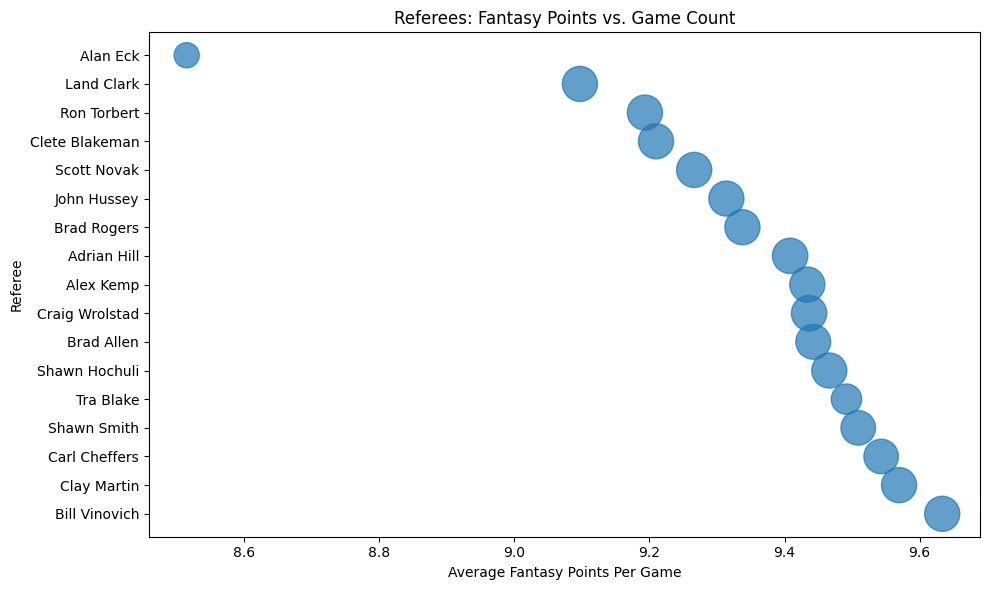

In [219]:
plt.figure(figsize=(10, 6))
plt.scatter(
    ref_avg['avg_points_per_game'],
    ref_avg['referee'],
    s=ref_avg['game_count'] * 10,  # bubble size = games
    alpha=0.7
)
plt.xlabel('Average Fantasy Points Per Game')
plt.ylabel('Referee')
plt.title('Referees: Fantasy Points vs. Game Count')
plt.tight_layout()
plt.show()
